# DSCI 571: Supervised Machine Learning I 

## Lecture 2: Machine Learning Fundamentals 

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar

### Three important things we are going to learn today 

1. [Generalization](#1)
2. [Data splitting](#2)
3. [The fundamental trade-off: underfitting, overfitting, the golden rule](#3)

## Lecture learning objectives

From this lecture, you will be able to 

- explain how decision boundaries change with the `max_depth` hyperparameter;
- explain the concept of generalization;
- split a dataset into train and test sets using `train_test_split` function;
- explain the difference between train, validation, test, and "deployment" data;
- identify the difference between training error, validation error, and test error;
- explain cross-validation and use `cross_val_score` and `cross_validate` to calculate cross-validation error;
- explain overfitting, underfitting, and the fundamental tradeoff;
- state the golden rule. 

In [1]:
# import the libraries
import graphviz
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

%pylab inline
# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

# Classifiers
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

Populating the interactive namespace from numpy and matplotlib


## Slide settings 

In [2]:
from pathlib import Path

from traitlets.config.manager import BaseJSONConfigManager

path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
tmp = cm.update(
    "rise",
    {
        "theme": "serif",
        "transition": "fade",
        "start_slideshow_at": "selected",
        "width": "100%",
        "height": "100%",
        "header": "",
        "footer": "",
        "scroll": True,
        "enable_chalkboard": True,
        "slideNumber": True,
        "center": False,
        "controlsLayout": "edges",
        "slideNumber": True,
        "hash": True,
    },
)

In [3]:
def display_tree(feature_names, tree):
    """ For binary classification only """
    dot = export_graphviz(tree, out_file=None, feature_names=feature_names, class_names=tree.classes_.astype(str), impurity=False)
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    #dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])', '', dot)
    dot = re.sub(     '(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
    return graphviz.Source(dot)

## 1. Generalization <a name="1"></a>

### Visualizing model complexity using decision boundaries

### Last lecture: Decision boundary

- A way to visualize what sort of examples will be classified as positive and negative.
- We assume geometric view of the data. (More on this in lecture 3.)
- Here the red region corresponds to "not A+" class and blue region corresponds to "A+" class. 
- And there is a line separating the red region and the blue region which is called the **decision boundary** of the model.

In [4]:
# Toy quiz2 grade data
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
classification_df.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+


In [5]:
X = classification_df.drop(["quiz2"], axis=1)
y = classification_df["quiz2"]

In [6]:
# Let's consiser a subset of the data with only two features
X_subset = X[["lab4", "quiz1"]]
X_subset.head()

,lab4,quiz1
0,91,92
1,83,91
2,80,80
3,91,89
4,92,85


In [7]:
def plot_decision_tree(model, 
              class_names=["A+", "not A+"]):
    return graphviz.Source(
                export_graphviz(
                model,
                out_file=None,
                feature_names=X_subset.columns,
                class_names=class_names,
                impurity=False,
            )
    )

In the following model, this decision boundary is created by asking one question. 

Error:   0.286


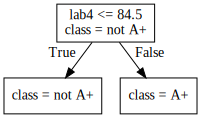

In [8]:
depth = 1
model = DecisionTreeClassifier(max_depth=depth) # decision stump
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
display_tree(X_subset.columns, model)

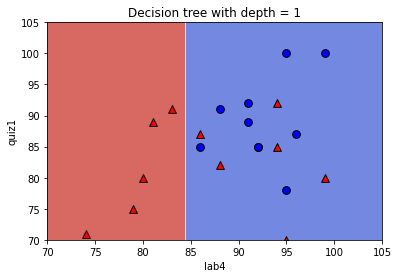

In [9]:
plot_classifier(X_subset.to_numpy(), y.to_numpy(), model, ticks=True, lims=(70,105,70,105))
plt.xlabel("lab4")
plt.ylabel("quiz1")
plt.title("Decision tree with depth = %d" % (depth));

### Trees with different depths 

- Let's examine how does the decision boundary change for different tree depths. 

In the following model, this decision boundary is created by asking two questions. 

Error:   0.190


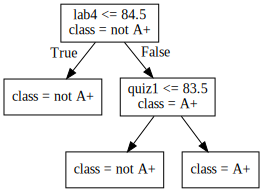

In [10]:
depth = 2
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
display_tree(X_subset.columns, model)

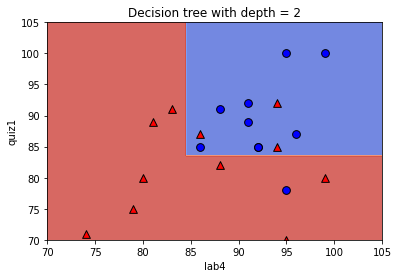

In [11]:
plot_classifier(X_subset.to_numpy(), y.to_numpy(), model, ticks=True, lims=(70,105,70,105))
plt.xlabel("lab4")
plt.ylabel("quiz1")
plt.title("Decision tree with depth = %d" % (depth));

Let's look at the decision boundary with depth = 4. 

Error:   0.048


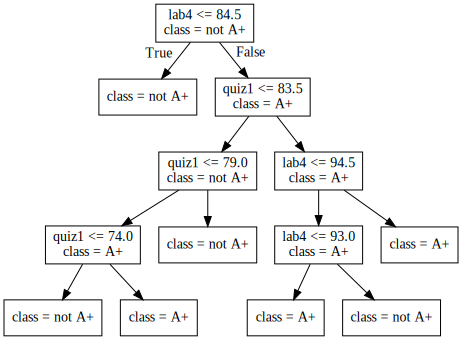

In [12]:
depth = 4
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
display_tree(X_subset.columns, model)

<Figure size 288x288 with 0 Axes>

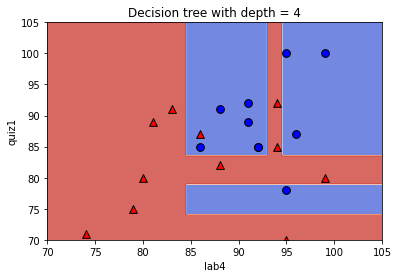

In [13]:
plt.figure(figsize=(4, 4))
plot_classifier(X_subset.to_numpy(), y.to_numpy(), model, ticks=True, lims=(70,105,70,105))
plt.xlabel("lab4")
plt.ylabel("quiz1")
plt.title("Decision tree with depth = %d" % (depth));

Let's look at the decision boundary with depth = 10. 

In [14]:
depth = 10
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
#display_tree(X_subset.columns, model)

Error:   0.000


<Figure size 288x288 with 0 Axes>

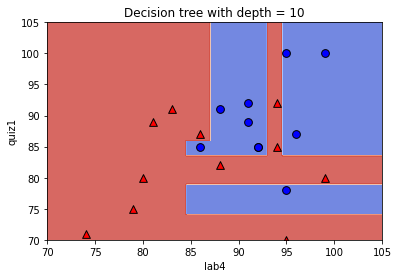

In [15]:
plt.figure(figsize=(4, 4))
plot_classifier(X_subset.to_numpy(), y.to_numpy(), model, ticks=True, lims=(70,105,70,105))
plt.xlabel("lab4")
plt.ylabel("quiz1")
plt.title("Decision tree with depth = %d" % (depth));

- Our model has 0% error!! 
- But it's also becoming more and more specific and sensitive to the training data.  
- Is it good or bad?

### Fundamental goal of ML

- **To generalize beyond what we see in the training examples**
- Example: Imagine that a learner sees the following images and corresponding labels. 

<img src='images/generalization-train.png' width="600" height="600" />


### Generalizing to unseen data

- Now the learner is presented with new images (1 to 4) for prediction. 
- What prediction would you expect for each image?   

<img src='images/generalization-predict.png' width="1000" height="1000" />

### Generalizing to unseen data

- Goal: We want the learner to be able to generalize beyond what it has seen in the training data.
- But these new examples should be representative of the training data. 
    - For instance, is it fair to expect the learner to label image 4 correctly?
    
<img src='images/generalization-predict.png' width="800" height="800" />

## Training error vs Generalization error 

- Given a model $M$, in ML, people usually talk about two kinds of errors of $M$. 
    1. Error on the training data: $error_{training}(M)$ 
    2. Error on the entire distribution $D$ of data: $error_{D}(M)$
- We are interested in the error on the entire distribution     
    - But we do not have access to the entire distribution ... 

## 2. Data Splitting <a name="2"></a>

### How to approximate generalization error? 

A common way is **data splitting**. 
- Keep aside some randomly selected portion from the training data.
- `fit` (train) a model on the training portion only. 
- `score` (assess) the trained model on this set aside data to get a sense of how well the model would be able to generalize.
- Pretend that the kept aside data is representative of the real distribution $D$ of data. 

In [16]:
# scikit-learn train_test_split
url = "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"
HTML("<iframe src=%s width=1000 height=650></iframe>" % url)

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


- We can pass `X` and `y` or a dataframe with both `X` and `y` in it. 
- We can also specify the train or test split sizes. 

### Simple train/test split 

- The picture shows an 80%-20% split of a toy dataset with 10 examples. 
- The data is shuffled before splitting. 
- Usually when we do machine learning we split the data before doing anything and put the test data in an imaginary chest lock. 

<img src='images/train-test-split.png' width="1500" height="1500" />

In [17]:
# Let's demonstrate this with the canada usa cities data
# The data is available in the data directory 
df = pd.read_csv("data/canada_usa_cities.csv")
X = df.drop(columns=["country"])
y = df["country"]
X

,longitude,latitude
0,-130.0437,55.9773
1,-134.4197,58.3019
2,-123.0780,48.9854
3,-122.7436,48.9881
4,-122.2691,48.9951
...,...,...
204,-72.7218,45.3990
205,-66.6458,45.9664
206,-79.2506,42.9931
207,-72.9406,45.6275


In [18]:
y

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
204    Canada
205    Canada
206    Canada
207    Canada
208    Canada
Name: country, Length: 209, dtype: object

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
) # 80%-20% train test split on X and y

# Print shapes
shape_dict = {
    "Data portion": ["X", "y", "X_train", "y_train", "X_test", "y_test"],
    "Shape": [
        X.shape,
        y.shape,
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
    ],
}

shape_df = pd.DataFrame(shape_dict)
HTML(shape_df.to_html(index=False))

Data portion,Shape
X,"(209, 2)"
y,"(209,)"
X_train,"(167, 2)"
y_train,"(167,)"
X_test,"(42, 2)"
y_test,"(42,)"


### Creating `train_df` and `test_df`

- Sometimes we want to keep the target in the train split for EDA or for visualization. 

In [20]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 123) # 80%-20% train test split on df
X_train, y_train = train_df.drop(columns=["country"]), train_df["country"] 
X_test, y_test = test_df.drop(columns=["country"]), test_df["country"]
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


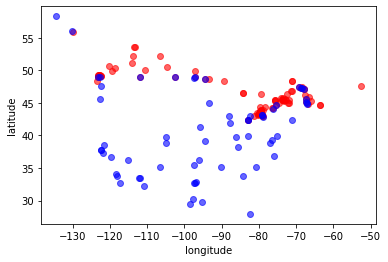

In [21]:
canada = train_df.query('country == "Canada"')
usa = train_df.query('country == "USA"')
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
plt.ylabel("latitude")
plt.xlabel("longitude");

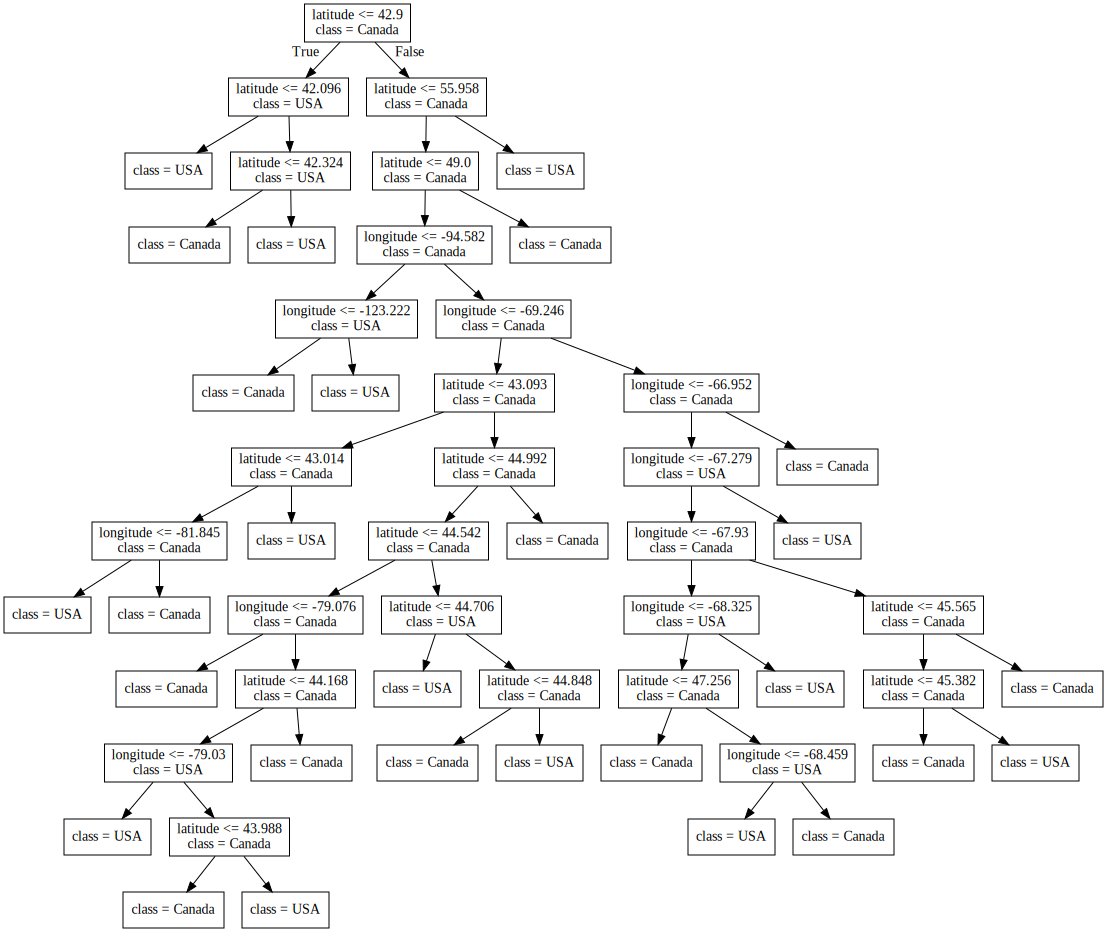

In [22]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
display_tree(X_train.columns, model)

In [23]:
# Let's examine the train and test accuracies with the split now.
print("Train accuracy:   %0.3f" % model.score(X_train, y_train))
print("Test accuracy:   %0.3f" % model.score(X_test, y_test))

Train accuracy:   1.000
Test accuracy:   0.738


Text(0, 0.5, 'lattitude')

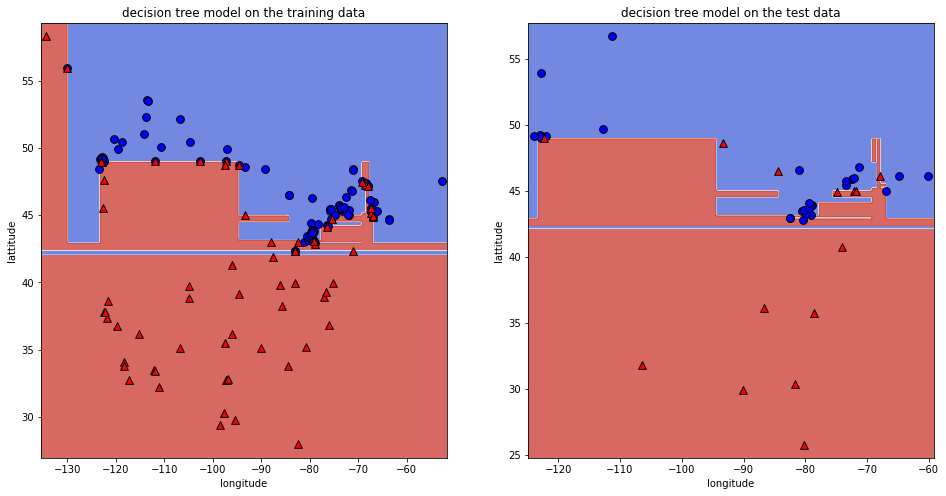

In [24]:
model.fit(X_train, y_train)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("decision tree model on the training data");
plot_classifier(X_train, y_train, model, ticks=True, ax=plt.gca())
plt.xlabel("longitude")
plt.ylabel("lattitude")
plt.subplot(1, 2, 2)
plt.title("decision tree model on the test data")
plot_classifier(X_test, y_test, model, ticks=True, ax=plt.gca())
plt.xlabel("longitude")
plt.ylabel("lattitude")

- Useful arguments of `train_test_split`: `test_size`, `train_size`, `random_state`

### `test_size`, `train_size` arguments

- Let's us specify how we want to split the data. 
- We can specify either of the two. See the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- There is no hard and fast rule on what split sizes should we use. 
    - It depends upon how much data is available to you. 
- Some common splits are 90/10, 80/20, 70/30 (training/test).
- In the above example, we used 80/20 split. 

### `random_state` argument

- The data is shuffled before splitting which is crucial step. (You will explore this in the lab.) 
- The `random_state` argument controls this shuffling. 
- In the example above we used `random_state=123`. If you run this notebook with the same `random_state` it should give you exactly the same split. 
    - Useful when you want reproducible results. 

### Train/validation/test split

- Some of you may have heard of "validation" data.
- Sometimes it's a good idea to have a separate data for hyperparameter tuning. 

<img src='images/train-valid-test-split.png' width="1500" height="1500" />

### Train/validation/test split

- We will try to use "validation" to refer to data where we have access to the target values.
  - But, unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  
- We will try to use "test" to refer to data where we have access to the target values 
  - But, unlike training and validation data, we neither use it in training nor hyperparameter optimization. 
  - We only use it **once** to evaluate the performance of the best performing model on the validation set.   
  - We lock it in a "vault" until we're ready to evaluate. 

Note that there isn't good concensus on the terminology of what is validation and what is test. 

### "Deployment" data

- After we build and finalize a model, we deploy it, and then the model deals with the data in the wild. 
- We will use "deployment" to refer to this data, where we do **not** have access to the target values.
- Deployment error is the thing we _really_ care about.
- We use validation and test errors as proxies for deployment error, and we hope they are similar.
- So, if our model does well on the validation and test data, we hope it will do well on deployment data.

### Summary of train, validation, test, and deployment data

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

You can typically expect $E_{train} < E_{validation} < E_{test} < E_{deployment}$.

### Cross-validation

Problems with having a single train/validation split

- Only using a portion of your data for training and only a portion for validation.
- If your dataset is small you might end up with a tiny training and/or validation set.
- You might be unlucky with your splits such that they don't align well or don't well represent your test data.

<img src='images/train-valid-test-split.png' width="1500" height="1500" />

### Cross-validation
- Cross-validation provides a solution to this problem. 
- Split the data into $k$ folds ($k>2$, often $k=10$). In the picture below $k=4$.
- Each "fold" gets a turn at being the validation set.
- Note that cross-validation doesn't shuffle the data; it's done in `train_test_split`.

<img src='images/cross-validation.png' width="1500">

### Cross-validation 

- Each fold gives a score and we usually average our $k$ results. 
- It's better to notice the variation in the scores across folds.  
- Gives a more "robust" measure of error on unseen data.

### Cross-validation using `scikit-learn`

In [25]:
from sklearn.model_selection import cross_val_score, cross_validate
model = DecisionTreeClassifier(max_depth=4)
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
cv_scores

array([0.76470588, 0.82352941, 0.70588235, 0.94117647, 0.82352941,
       0.82352941, 0.70588235, 0.9375    , 0.9375    , 0.9375    ])

In [26]:
print(f"Average cross-validation score = {np.mean(cv_scores):.2f}")
print(f"Standard deviation of cross-validation score = {np.std(cv_scores):.2f}")

Average cross-validation score = 0.84
Standard deviation of cross-validation score = 0.09


Under the hood

- It creates `cv` folds on the data.
- In each fold, it fits the model on the training portion and scores on the validation portion. 
- The output is a list of validation scores in each fold.

### `cross_validate`

- Similar to `cross_val_score` but more powerful.
- Let's us access training and validation scores.  

In [27]:
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002018,0.001116,0.764706,0.913333
1,0.001408,0.001055,0.823529,0.906667
2,0.001446,0.001308,0.705882,0.906667
3,0.001410,0.001007,0.941176,0.900000
4,0.001381,0.001015,0.823529,0.906667
5,0.001384,0.001011,0.823529,0.913333
6,0.001378,0.001084,0.705882,0.920000
7,0.001439,0.001028,0.937500,0.900662
8,0.001411,0.001015,0.937500,0.900662
9,0.001383,0.001013,0.937500,0.900662


In [28]:
pd.DataFrame(pd.DataFrame(scores).mean())

,0
fit_time,0.001466
score_time,0.001065
test_score,0.840074
train_score,0.906865


### Questions on cross validation

1. We carry out cross-validation to avoid reusing the same validation set again and again. With $k$-fold cross-validation, you split your $n$ examples into $k$ folds. For each fold, you train on __ examples 
        1. n
        2. n/k
        3. n - n/k  or n(k-1)/k
        4. k 
    

2. With $k$-fold cross-validation, you split your $n$ examples into $k$ folds. For each fold, when you are done, you add up the accuracies from each fold and divide by __
        1. n
        2. n/k
        3. n - n/k or n(k-1)/k
        4. k    

#### Our typical supervised learning set up is as follows: 

- We are given training data with features `X` and target `y`
- We split the data into train and test portions: `X_train, y_train, X_test, y_test`
- We carry out hyperparameter optimization using cross-validation on the train portion: `X_train` and `y_train`. 
- We assess our best performing model on the test portion: `X_test` and `y_test`.  
- What we care about is the **test error**, which tells us how well our model can be generalized.
- If this test error is "reasonable" we deploy the model which will be used on new unseen examples.
- How do we know whether this test error is reasonable? 

### 3. Underfitting, overfitting, the fundamental tradeoff, the golden rule <a name="3"></a>

### Types of errors

Imagine that your train and validation errors do not align with each other. How do you diagnose the problem?  

We're going to think about 4 types of errors:

- $E_\textrm{train}$ is your training error (or mean train error from cross-validation).
- $E_\textrm{valid}$ is your validation error (or mean validation error from cross-validation).
- $E_\textrm{test}$ is your test error.
- $E_\textrm{best}$ is the best possible error you could get for a given problem.

Question: Why is $E_\textrm{best} \gt 0$?

### Underfitting 

- Your model is too simple, e.g. `DecisionTreeClassifier` with `max_depth=1` or `DummyClassifier`
- The model is so simple that it doesn't even capture the patterns in the training data.
- So even the training error is not that low.
- In this case, you likely have very little overfitting (because you have very little fitting, period); hence $E_\textrm{train}\lesssim E_\textrm{valid}$.
- Both train and validation errors are bad.  
- The gap between train and validation error is lower.
- $E_\textrm{best} \lt E_\textrm{train} \lesssim E_\textrm{valid}$

In [29]:
model = DecisionTreeClassifier(max_depth=1)

scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
print("Train error:   %0.3f" % (1 - np.mean(scores["train_score"])))
print("Validation error:   %0.3f" % (1 - np.mean(scores["test_score"])))

Train error:   0.166
Validation error:   0.190


### Overfitting 

- Train error is low but validation error is much higher.  
- The gap between train and validation error is bigger.
- $E_\textrm{train} \lt E_\textrm{best}  \lt E_\textrm{valid}$
- If $E_\textrm{train}$ is low, that is the overfitting scenario. It is fairly common to have at least a bit of this.

- $E_\textrm{valid}$ cannot be smaller than $E_\textrm{best}$ basically by definition. In reality you won't have them equal.

In [30]:
# Let's try a decion tree with no depth
model = DecisionTreeClassifier()
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
print("Train error:   %0.3f" % (1 - np.mean(scores["train_score"])))
print("Validation error:   %0.3f" % (1 - np.mean(scores["test_score"])))

Train error:   0.000
Validation error:   0.191


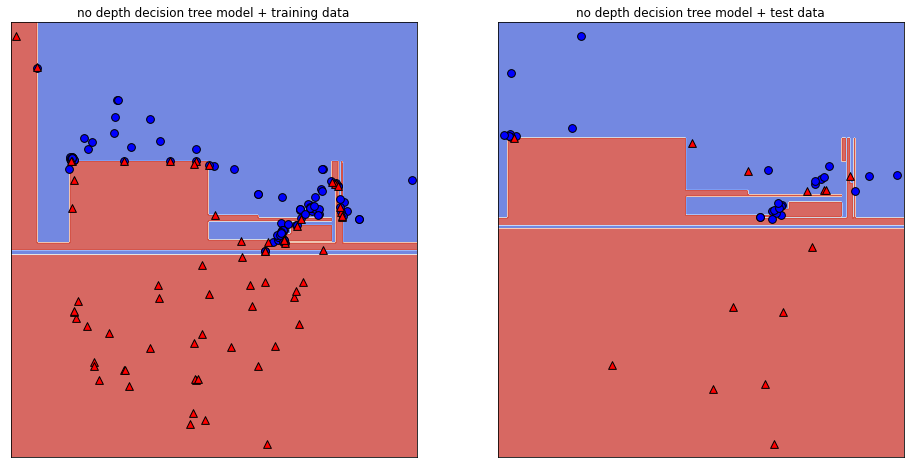

In [31]:
model.fit(X_train, y_train)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("no depth decision tree model + training data");
plot_classifier(X_train, y_train, model, ax=plt.gca())

plt.subplot(1, 2, 2)
plt.title("no depth decision tree model + test data")
plot_classifier(X_test, y_test, model, ax=plt.gca())

- We see that validation error does not necessarily decrease with training error. 
    - Here, for larger depths we observe that the training error is close to 0 but validation error keeps increasing.  
- As we make more complex models we start encoding random quirks in the data, which are not grounded in reality.  
- These random quirks do not generalize well to new data. 
- This problem of failing to be able to generalize to the validation data or test data is called **overfitting**.

## The "fundamental tradeoff" of supervised learning:

As you increase model complexity, $E_\textrm{train}$ tends to go down but $E_\textrm{valid}-E_\textrm{train}$ tends to go up.

- If your model is very simple, like `DummyClassifier`, then you won't really learn any "specific patterns" of the training set, but your model won't be very good in general. This is underfitting.
- If your model is very complex, like a `DecisionTreeClassifier(max_depth=None)`, then you will learn unreliable patterns that get every single training example correct, but there will be a huge gap between training error and validation error. This is overfitting.

### Bias vs variance tradeoff 

- This fundamental trade-off is also called the bias/variance tradeoff.
- Bias $\rightarrow$ the tendency to consistently learn the same wrong thing (high bias means underfitting)
- Variance $\rightarrow$ the tendency to learn random things irrespective of the real signal (high variance means overfitting)

<img src='images/darts_overfitting.png' width="500" height="500" />

[Source](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

### Overfitting and the fundamental tradeoff True/False questions

1. In supervised learning, the training error is always lower than the validation error.
1. The fundamental tradeoff of ML states that as training error goes down, validation error goes up.
2. More "complicated" models are more likely to overfit than "simple" ones.
3. If we had an infinite amount of training data, overfitting would not be a problem.
4. If our training error is extremely low, that means we're overfitting.

<br><br><br><br><br><br><br><br>

### How to pick a model that would generalize better?

- We want to avoid both underfitting and overfitting.  
- Here is a typical workflow to pick the best hyperparameters with a systematic search over some possible hyperparameter values.   

In [32]:
results_dict = {"depth": [], "mean_train_score": [], "mean_cv_score": [], "std_cv_score" : [], "std_train_score":[]}
param_grid = {"max_depth": np.arange(1, 30)}

for depth in param_grid["max_depth"]:
    model = DecisionTreeClassifier(max_depth=depth)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("depth")

In [33]:
results_df

,mean_train_score,mean_cv_score,std_cv_score,std_train_score
depth,,,,
1,0.834349,0.809926,0.084735,0.008808
2,0.844989,0.804044,0.085624,0.006376
3,0.862967,0.804412,0.089631,0.016135
4,0.906865,0.840074,0.090119,0.006472
5,0.918848,0.851838,0.078801,0.012076
6,0.930817,0.815074,0.060613,0.017382
7,0.954115,0.839706,0.086287,0.017165
8,0.972733,0.821324,0.090253,0.011293
9,0.979382,0.821691,0.100647,0.011702


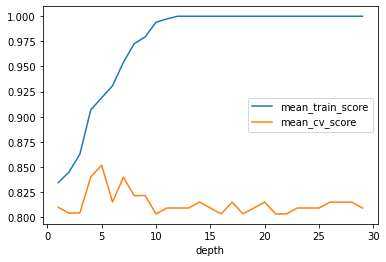

In [34]:
results_df[["mean_train_score", "mean_cv_score"]].plot()

In [35]:
def cross_validate_std(*args, **kwargs):
    """Like cross_validate, except also gives the standard deviation of the score"""
    res = pd.DataFrame(cross_validate(*args, **kwargs))
    res_mean = res.mean()
    res_mean["std_test_score"] = res["test_score"].std()
    if "train_score" in res:
        res_mean["std_train_score"] = res["train_score"].std()
    return res_mean

In [36]:
scores_std = cross_validate_std(model, X_train, y_train, cv=10, return_train_score=True)


### Which hyperparameters should we pick? 

- There are many subtleties here and there is no perfect answer. 
- A common practice is to pick the model with minimum cross-validation error. 

In [37]:
best_depth = results_df.index.values[np.argmax(results_df["mean_cv_score"])]
print(
    "The maximum validation score is %0.3f at max_depth = %d "
    % (
        np.max(results_df["mean_cv_score"]),
        best_depth,
    )
)

The maximum validation score is 0.852 at max_depth = 5 


### Comparing test score with cross-validation score

- Let's pick `max_depth`= 5
- And try this model on the test set. 

In [38]:
model = DecisionTreeClassifier(max_depth=best_depth)
model.fit(X_train, y_train)
print(f"Error on test set: {1 - model.score(X_test, y_test):.2f}")

Error on test set: 0.19


- Is the test error comparable with the cross-validation error?
- Do we feel confident that this model would give similar performace when deployed? 

## The golden rule <a name="4"></a>

- Even though we care the most about test error **THE TEST DATA CANNOT INFLUENCE THE TRAINING PHASE IN ANY WAY**. 
- We have to be very careful not to violate it while developing our ML pipeline. 
- Even experts end up breaking it sometimes which leads to misleading results and lack of generalization on the real data. 

## Golden rule violation: Example 1  

<img src='images/golden_rule_violation.png' width="500" height="500" />

<blockquote>
   ... He attempted to reproduce the research, and found a major flaw: there was some overlap in the data used to both train and test the model. 
</blockquote>    

#### Golden rule violation: Example 2  

<img src='images/golden_rule_violation_2.png' width="500" height="500" />

<blockquote>
  ... The Challenge rules state that you must only test your code twice a week, because there’s an element of chance to the results. Baidu has admitted that it used multiple email accounts to test its code roughly 200 times in just under six months – over four times what the rules allow.
</blockquote>


### How can we avoid violating golden rule? 

- Recall that when we split data, we put our test set in an imaginary vault.

<img src='images/train-test-split.png' width="1500" height="1500" />

### Here is the workflow we'll generally follow. 

- **Splitting**: Before doing anything, split the data `X` and `y` into `X_train`, `X_test`, `y_train`, `y_test` or `train_df` and `test_df` using `train_test_split`.  
- **Select the best model using cross-validation**: Use `cross_validate` with `return_train_score = True` so that we can get access to training scores in each fold. (If we want to plot train vs validation error plots, for instance.) 
- **Scoring on test data**: Finally score on the test data with the chosen hyperparameters to examine the generalization performance.

**Again, there are many subtleties here we'll discuss the golden rule multiple times throughout the course and in the program.**  

### Revisit: Learning outcomes 

At this point you should feel comfortable about the following:  

- explain how decision boundaries change with the `max_depth` hyperparameter;
- explain the concept of generalization;
- split a dataset into train and test sets using `train_test_split` function;
- explain the difference between train, validation, test, and "deployment" data;
- identify the difference between training error, validation error, and test error;
- explain cross-validation and use `cross_val_score` and `cross_validate` to calculate cross-validation error;
- explain overfitting, underfitting, and the fundamental tradeoff;
- state the golden rule. 


### Practice exercises (~15 mins) 

- We'll be working on [some practice exercise](https://intro-machine-learning.netlify.app/en/module3) in breakout rooms.
- This is for your practice and **NOT** for credit.
- Work on the following exercises in [Module 3](https://intro-machine-learning.netlify.app/en/module3): 14, 16, 18, 19, 20. 

Some background on the online course above: Hayley, Mike, and I are working on this online (and a bit lighter) version of 571. **Note that this is work in progress and it's in BETA. Some of the work is not reviewed or finalized yet.** If you see any problems, will be great if you can let us know. 